In [92]:
from PIL import Image
from random import choice
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch import optim

In [93]:
from glob import glob 

In [94]:
originals = glob("ConferenceVideoSegmentationDataset/original_training/*")
# segments  = glob("ConferenceVideoSegmentationDataset/ground_truth_training/*")

In [95]:
original_pth= choice(originals)
segment_pth = original_pth.replace('original_training', 'ground_truth_training').replace('original', 'gt')

In [96]:
original_pth

'ConferenceVideoSegmentationDataset/original_training/original2_160.jpg'

In [97]:
segment_pth

'ConferenceVideoSegmentationDataset/ground_truth_training/gt2_160.jpg'

In [98]:
img_org = Image.open(original_pth)
img_seg = Image.open(segment_pth)

In [99]:
%matplotlib inline

In [100]:
img_arr = np.array(img_org)
seg_arr = np.array(img_seg)


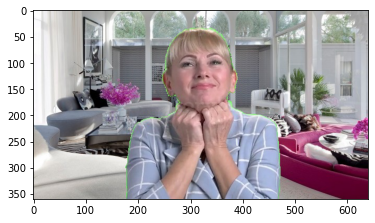

In [101]:
plt.imshow(img_arr)
plt.show()



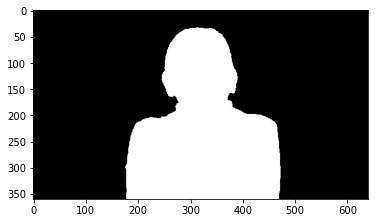

In [102]:
plt.imshow(seg_arr)
plt.show()



In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [104]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [105]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os 
from PIL import Image


class HumanSegmentation(Dataset):
    def __init__(self, img_transforms = None, mask_transforms = None) :
        super(HumanSegmentation,self).__init__()
        self.imgs = glob("ConferenceVideoSegmentationDataset/original_training/*")
        self.masks = [i.replace('original_training', 'ground_truth_training').replace('original', 'gt')
                     for i in self.imgs]
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms


    def __len__(self):
        return len(self.imgs)
    

    def __getitem__(self, index):
        img = Image.open(self.imgs[index])
        mask = Image.open(self.masks[index])
        if self.img_transforms:
            img = self.img_transforms(img)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return img, mask


In [106]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [107]:
from torchvision import transforms
IMG_Trasforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5))
    ])

MASK_Trasforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5),
        (0.5))
    ])

dataset_ = HumanSegmentation(IMG_Trasforms, MASK_Trasforms)
training_loader = DataLoader(dataset_, batch_size = 1)

In [111]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS   = 10
LEARNING_RATE= 2e-4
BATCH_SIZE   = 8



model = UNet(3,1).to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score


if DEVICE == "cuda":
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

criterion = nn.CrossEntropyLoss()


model.train()

for epoch in range(1, 1+1):
    tqdm_iter = tqdm(enumerate(training_loader), total = len(training_loader), leave = False)
    epoch_loss = 0
    for batch_idx, (img,mask) in tqdm_iter:
        imgs = img.to(device=DEVICE, dtype=torch.float32)
        target = mask.to(device=DEVICE, dtype=torch.long)
        target = target.squeeze(1)

        if DEVICE == "cuda":
            with torch.cuda.amp.autocast(enabled=amp):
                masks_pred = model(imgs)
                loss = criterion(masks_pred, target) \
                   + dice_loss(F.softmax(masks_pred, dim=1).float(),
                               F.one_hot(target, model.n_classes).permute(0, 3, 1, 2).float(),
                               multiclass=True)
            
                
            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()
            epoch_loss += loss.item()
            torch.save(model.state_dict(), 'checkpoints/checkpoint_epoch{}.pth'.format(epoch + 1))
            tqdm_iter.set_description(f"Training Epoch : [{epoch + 1}/{NUM_EPOCHS}] ")
            tqdm_iter.set_postfix(
                batch_loss="%.2f" % loss.item(),
                epoch_loss= "%.2f" % epoch_loss
            )
        else:
            masks_pred = model(imgs)
            print(masks_pred.shape)
            print(target.shape)
            
            loss = criterion(masks_pred, target) \
                   + dice_loss(F.softmax(masks_pred, dim=1).float(),
                               F.one_hot(target, model.n_classes).permute(0, 3, 1, 2).float(),
                               multiclass=True)
            

        
#             loss = criterion(masks_pred, target) \
#                        + dice_loss(masks_pred,
#                                    target,
#                                    multiclass=False)
        
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()
            epoch_loss += loss.item()
            torch.save(model.state_dict(), 'checkpoints/checkpoint_epoch{}.pth'.format(epoch + 1))
            tqdm_iter.set_description(f"Training Epoch : [{epoch + 1}/{NUM_EPOCHS}] ")
            tqdm_iter.set_postfix(
                batch_loss="%.2f" % loss.item(),
                epoch_loss= "%.2f" % epoch_loss
            )
        
        break


torch.Size([1, 1, 360, 640])
torch.Size([1, 360, 640])


IndexError: Target -1 is out of bounds.